In [102]:
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.decomposition import NMF, LatentDirichletAllocation, FactorAnalysis, PCA
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
import sys
sys.path.append('../data_science')
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns



np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
import pandas as pd

### Latent Variable Models

Assume that we have n students and k courses. All students have grades for all courses. Factor analysis assumes that actually there are few parameters (latent variables) which determine students' grades. For example IQ and study_time might be the basic factors which determine the grades. 

Let us assume that there are 5 courses. We will assume that IQ scores and study times of the students determine the grades they get from these courses. In other words we can model the grade of a student $s$ for course $c$ as follows:

$$
grade_{sc} = IQ_s*F_c + ST_s*F_c
$$

$F_c$ is the factor for each course which together with IQ and study time determine the grade. This is also reasonable to assume since otherwise a student would get the same grade from all courses.


In [158]:
n = 100
k = 5

# Students IQs normally distributed with mean = 100, std = 20
IQ = np.random.normal(100,20,n).reshape(n,-1)
ST = np.random.normal(10,2,n).reshape(n,-1)
IQST = np.hstack([IQ,ST])

# Course factors,  what do these values represent? why do we need them?
CF = np.random.rand(2,5)

print(CF)
print(IQST[:10])


[[0.01 0.79 0.49 0.42 0.4 ]
 [0.33 0.91 0.07 0.19 0.02]]
[[ 74.51   6.87]
 [ 90.79  10.52]
 [125.67   6.74]
 [ 82.23   8.87]
 [145.3    6.68]
 [ 97.57  12.28]
 [134.     8.28]
 [ 93.85   7.15]
 [111.31  11.34]
 [ 76.71  11.3 ]]


In [159]:
GM = np.dot(IQST,CF)
GM[:10]

array([[  3.32,  64.84,  37.15,  32.47,  29.64],
       [  4.75,  80.95,  45.42,  39.97,  36.16],
       [  4.03, 104.95,  62.3 ,  53.84,  49.89],
       [  4.08,  72.72,  41.09,  36.08,  32.74],
       [  4.29, 120.33,  71.95,  62.03,  57.66],
       [  5.42,  87.89,  48.88,  43.15,  38.88],
       [  4.65, 112.9 ,  66.51,  57.62,  53.22],
       [  3.69,  80.29,  46.68,  40.61,  37.3 ],
       [  5.31,  97.83,  55.57,  48.71,  44.3 ],
       [  4.79,  70.58,  38.55,  34.24,  30.6 ]])

In [105]:
pd.DataFrame(GM).corr()

,0,1,2,3,4
0,1.000000,0.768615,0.723923,0.994148,0.840067
1,0.768615,1.000000,0.997743,0.695013,0.992721
2,0.723923,0.997743,1.000000,0.645163,0.982392
3,0.994148,0.695013,0.645163,1.000000,0.776549
4,0.840067,0.992721,0.982392,0.776549,1.000000


<Axes: >

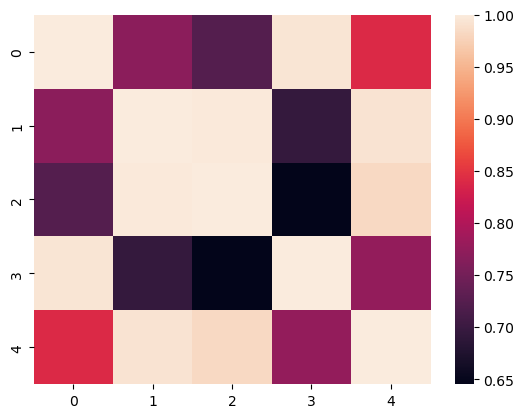

In [106]:
sns.heatmap(pd.DataFrame(GM).corr())

### Factor Analysis

In [107]:
fa = FactorAnalysis(n_components=2).fit(GM)

In [108]:
L = fa.components_
print(L)
F = fa.transform(GM)
print(F[:10])

[[ -1.5  -17.53 -18.48  -1.56  -8.05]
 [  1.29   0.26  -0.97   1.66   1.1 ]]
[[ 0.72  1.09]
 [ 0.1  -0.44]
 [-0.26 -0.89]
 [-1.76  0.65]
 [ 0.37  0.31]
 [ 0.23 -0.84]
 [-0.56 -0.03]
 [ 0.85 -1.67]
 [ 0.16 -1.19]
 [-1.57  1.08]]


In [109]:
GM_recovered = fa.mean_ + np.dot(F,L)
GM_recovered[:10]

array([[ 15.08,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

In [110]:
GM[:10]

array([[ 15.08,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

### TruncatedSVD and Nonnegative Matrix Factorization

We can also do similar factorizations with TruncatedSVD or NMF.

In [111]:
from scipy.sparse import csr_matrix


# Create a dense matrix
dense_matrix = np.array([[0, 0, 0, 0],
                        [0, 5, 0, 0],
                        [0, 0, 0, 8]])

# Convert the dense matrix to a sparse matrix
sparse_matrix = csr_matrix(dense_matrix)

print(sparse_matrix)

  (1, 1)	5
  (2, 3)	8


In [112]:
from sklearn.decomposition import TruncatedSVD

In [113]:
tsvd = TruncatedSVD(n_components=2).fit(GM)
W = tsvd.transform(GM)
H = tsvd.components_
print(W[:10])
print(H)

[[130.96   4.78]
 [147.07  -0.53]
 [156.65  -2.48]
 [197.01  -1.85]
 [140.03   2.  ]
 [143.49  -1.25]
 [164.7   -0.93]
 [126.77  -2.01]
 [145.33  -2.3 ]
 [191.87  -0.33]]
[[ 0.1   0.66  0.66  0.11  0.33]
 [ 0.49  0.05 -0.43  0.64  0.4 ]]


In [114]:
GM_recovered = np.dot(W,H)
GM_recovered[:10]

array([[ 15.08,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

In [115]:
GM[:10]

array([[ 15.08,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

In [116]:
nmf = NMF(n_components=2).fit(GM)
W = nmf.transform(GM)
H = nmf.components_
print(W[:10])
print(H)

[[3.1  0.  ]
 [2.88 0.31]
 [2.78 0.48]
 [3.69 0.5 ]
 [3.11 0.1 ]
 [2.7  0.36]
 [3.18 0.37]
 [2.25 0.39]
 [2.58 0.44]
 [3.81 0.38]]
[[ 4.6  27.99 27.33  5.35 14.56]
 [ 7.42 53.68 53.8   8.45 26.85]]


/Users/tevfikaytekin/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [117]:
GM_recovered = np.dot(W,H)
GM_recovered[:10]

array([[ 14.25,  86.63,  84.59,  16.57,  45.08],
       [ 15.56,  97.24,  95.38,  18.04,  50.27],
       [ 16.36, 103.57, 101.79,  18.94,  53.38],
       [ 20.72, 130.26, 127.88,  24.01,  67.24],
       [ 15.09,  92.6 ,  90.56,  17.53,  48.08],
       [ 15.1 ,  94.87,  93.14,  17.5 ,  48.98],
       [ 17.39, 108.89, 106.84,  20.15,  56.26],
       [ 13.24,  83.82,  82.38,  15.33,  43.19],
       [ 15.18,  96.08,  94.43,  17.57,  49.52],
       [ 20.34, 126.86, 124.39,  23.59,  65.61]])

In [118]:
GM[:10]

array([[ 15.08,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

# Missing Value
Suppose that one of the values in the GM matrix is missing. Can we find/recover it? Unfortunately FA and NMF will not work if there are missing values in the dataset.

In [119]:
GM00 = GM[0,0]
GM[0,0] = np.nan
GM[:10]

array([[   nan,  86.68,  83.83,  17.65,  45.74],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

In [120]:
fa = FactorAnalysis(n_components=2).fit(GM)
#tsvd = TruncatedSVD(n_components=2).fit(GM)
#nmf = NMF(n_components=2).fit(GM)



ValueError: Input X contains NaN.
FactorAnalysis does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### First Solution

One solution might be to set missing values to zero. This might work when there are a few missing values, but if most of the data is missing such as the case in rec. sys. this might not give good results.

In [121]:
GM[0,0] = 0
L = fa.components_
F = fa.transform(GM)
GM_recovered = fa.mean_ + np.dot(F,L)
GM_recovered[:10]

array([[ 11.27,  85.37,  86.09,  12.74,  42.28],
       [ 14.02,  97.07,  96.7 ,  16.05,  49.01],
       [ 13.99, 103.31, 103.83,  15.88,  51.44],
       [ 18.22, 129.98, 130.03,  20.78,  65.2 ],
       [ 14.59,  92.54,  90.99,  16.88,  47.67],
       [ 13.32,  94.68,  94.67,  15.19,  47.52],
       [ 15.53, 108.69, 108.44,  17.76,  54.75],
       [ 11.32,  83.6 ,  84.03,  12.84,  41.62],
       [ 12.98,  95.84,  96.32,  14.73,  47.72],
       [ 18.47, 126.66, 125.99,  21.17,  64.08]])

In [122]:
nmf = NMF(n_components=2)
nmf.fit(GM)
W = nmf.transform(GM)
H = nmf.components_
GM_recovered = np.dot(W,H)
GM_recovered[:10]


/Users/tevfikaytekin/anaconda3/envs/sklearn-env/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


array([[ 13.37,  85.62,  84.26,  15.51,  44.04],
       [ 15.53,  97.24,  95.38,  18.03,  50.26],
       [ 16.32, 103.57, 101.8 ,  18.94,  53.38],
       [ 20.68, 130.26, 127.89,  24.  ,  67.23],
       [ 15.08,  92.6 ,  90.57,  17.51,  48.06],
       [ 15.07,  94.88,  93.14,  17.49,  48.98],
       [ 17.35, 108.89, 106.85,  20.14,  56.25],
       [ 13.21,  83.82,  82.38,  15.33,  43.19],
       [ 15.14,  96.08,  94.43,  17.57,  49.52],
       [ 20.31, 126.86, 124.4 ,  23.57,  65.6 ]])

### MF with SGD

In [132]:
GM[0,0] = GM00


In [160]:
x = GM.shape[0]
y = GM.shape[1] 
c1 = []
c2 = []
c3 = []
for i in range(x):
    for j in range(y):
        c1.append(i)
        c2.append(j)
        c3.append(GM[i,j])
SM = pd.DataFrame({"StudentID":c1,"CourseID":c2,"Grade":c3})
SM

,StudentID,CourseID,Grade
0,0,0,3.322196
1,0,1,64.837506
2,0,2,37.148155
3,0,3,32.471649
4,0,4,29.640991
...,...,...,...
495,99,0,3.964945
496,99,1,87.080379
497,99,2,50.690633
498,99,3,44.080791


In [161]:
SM = SM.iloc[1:,:]
SM

,StudentID,CourseID,Grade
1,0,1,64.837506
2,0,2,37.148155
3,0,3,32.471649
4,0,4,29.640991
5,1,0,4.746402
...,...,...,...
495,99,0,3.964945
496,99,1,87.080379
497,99,2,50.690633
498,99,3,44.080791


In [135]:
class MF:
    """
    prefs: matrix of prefences, column0=userid, column1=itemid, column2=pref, column3=timestamp 
    """
    def __init__(self, prefs, alpha=0.03, mylambda=0.1, n_factors = 10, n_iters = 50):
        self.alpha = alpha
        self.mylambda = mylambda
        self.n_iters = n_iters
        self.item_factors = {}
        self.user_factors = {}
        self.prefs = prefs
        # prefs is a matrix containing u, i, r values in each row. This is useful to shuffle and pass over
        # the data multiple times in an efficient way in the fit() method.
        for r in range(self.prefs.shape[0]):
            self.user_factors[self.prefs.iloc[r,0]] = np.random.rand(n_factors,1) - 0.5
            self.item_factors[self.prefs.iloc[r,1]] = np.random.rand(n_factors,1) - 0.5
        print("Finished initialization")
        
     
    def calc_error(self, X):
        error = 0
        for i in range(X.shape[0]):
            u_idx = X.iloc[i,0]
            i_idx = X.iloc[i,1]
            error += np.abs(X.iloc[i,2] - np.dot(self.user_factors[u_idx].T, self.item_factors[i_idx])[0,0])
        return error/X.shape[0]

        #print("Random Predictor Error:",error/self.prefs.shape[0])
        
    def fit(self, verbose=False, method="SGD"):
        if (method == "Random"):
            error = 0
            for i in range(self.prefs.shape[0]):
                u_idx = self.prefs.iloc[i,0]
                i_idx = self.prefs.iloc[i,1]
                error += np.abs(self.prefs.iloc[i,2] - np.random.randint(1,6))
            return error/self.prefs.shape[0]
            
        elif (method == "SGD"):
            if (verbose): 
                print("Initial error: ", self.calc_error(self.prefs))                      
            for t in range(self.n_iters):
                self.prefs = shuffle(self.prefs)
                for r in range(self.prefs.shape[0]):
                    u = self.prefs.iloc[r,0]
                    i = self.prefs.iloc[r,1]
                    error = self.prefs.iloc[r,2] - np.dot(self.user_factors[u].T, self.item_factors[i])[0,0]
                    self.user_factors[u] = self.user_factors[u] + self.alpha*(error*self.item_factors[i] - self.mylambda*self.user_factors[u])
                    self.item_factors[i] = self.item_factors[i] + self.alpha*(error*self.user_factors[u] - self.mylambda*self.item_factors[i])  
            
                if (verbose): 
                    print("Iteration: ", t)
                if (verbose): 
                    print("Train error: ", self.calc_error(self.prefs))                      


In [162]:
mf = MF(SM, alpha=0.001, n_factors = 2, n_iters=50)
mf.fit(verbose=True, method="SGD")

Finished initialization
Initial error:  45.30426847962915
Iteration:  0
Train error:  45.300425519818255
Iteration:  1
Train error:  45.25093688894465
Iteration:  2
Train error:  44.524451894196126
Iteration:  3
Train error:  35.556011713233815
Iteration:  4
Train error:  7.210569893141565
Iteration:  5
Train error:  1.7037454990877425
Iteration:  6
Train error:  0.7632006974129658
Iteration:  7
Train error:  0.6515080531582107
Iteration:  8
Train error:  0.6190395525195147
Iteration:  9
Train error:  0.612040445732923
Iteration:  10
Train error:  0.6160043324594361
Iteration:  11
Train error:  0.6167477063948874
Iteration:  12
Train error:  0.6193560044391969
Iteration:  13
Train error:  0.6151905932100941
Iteration:  14
Train error:  0.6194105167818923
Iteration:  15
Train error:  0.6248592955704304
Iteration:  16
Train error:  0.6126149373634564
Iteration:  17
Train error:  0.6150359253427591
Iteration:  18
Train error:  0.6216275594270099
Iteration:  19
Train error:  0.619306510711

In [163]:
U = pd.DataFrame()
for i in range(n):
  U = pd.concat([U,pd.DataFrame(mf.user_factors[i].T)])
U

,0,1
0,2.690306,1.105234
0,3.401613,1.180867
0,4.398141,1.821422
0,3.168354,0.796883
0,5.123247,1.878710
...,...,...
0,3.453876,0.877622
0,4.944595,1.957179
0,4.375463,1.380185
0,4.491752,1.411832


In [164]:
I = pd.DataFrame()
for i in range(k):
  I = pd.concat([I,pd.DataFrame(mf.item_factors[i].T)])
I

,0,1
0,1.097536,0.410712
0,20.787912,7.939462
0,11.831068,4.552522
0,10.433483,3.811076
0,9.485821,3.513032


In [165]:
GM_recovered = np.dot(U,I.T)[:10]
GM_recovered

array([[  3.41,  64.7 ,  36.86,  32.28,  29.4 ],
       [  4.22,  80.09,  45.62,  39.99,  36.42],
       [  5.58, 105.89,  60.33,  52.83,  48.12],
       [  3.8 ,  72.19,  41.11,  36.09,  32.85],
       [  6.39, 121.42,  69.17,  60.61,  55.2 ],
       [  4.58,  87.  ,  49.55,  43.48,  39.59],
       [  5.99, 113.79,  64.82,  56.81,  51.73],
       [  4.25,  80.65,  45.95,  40.23,  36.65],
       [  5.13,  97.47,  55.53,  48.62,  44.29],
       [  3.65,  69.38,  39.54,  34.54,  31.48]])

In [166]:
GM[:10]

array([[  3.32,  64.84,  37.15,  32.47,  29.64],
       [  4.75,  80.95,  45.42,  39.97,  36.16],
       [  4.03, 104.95,  62.3 ,  53.84,  49.89],
       [  4.08,  72.72,  41.09,  36.08,  32.74],
       [  4.29, 120.33,  71.95,  62.03,  57.66],
       [  5.42,  87.89,  48.88,  43.15,  38.88],
       [  4.65, 112.9 ,  66.51,  57.62,  53.22],
       [  3.69,  80.29,  46.68,  40.61,  37.3 ],
       [  5.31,  97.83,  55.57,  48.71,  44.3 ],
       [  4.79,  70.58,  38.55,  34.24,  30.6 ]])